# Проект: HR аналитика

**Проект направлен на оптимизацию управления персоналом посредством решения двух задач - предсказания уровня удовлетворенности и предсказания оттока сотрудников.**

### Цель проекта
- **Задача 1: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика**
- **Задача 2: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании**

### [Задача 1:](#task1)

#### [1. Обзор данных](#load1)
- **Загрузить и проанализировать входные данные**

#### [2. Предобработка](#data_preprocessing1)
- **Проверить на пропуски и дубликаты**
- **Выявить другие проблемы с данными**

#### [3. Провести исследовательский анализ данных (EDA)](#eda1)
- **Изучить распределение категориальных признаков**
- **Изучить распределение количественных признаков**
- **Провести корреляционный анализ признаков**

#### [4. Подготовка данных](#pipeline1)
- **Построить pipeline для выбора модели и гиперпарамиетров.** 

#### [5. Обучение модели](#model1)  
- **Задать метрику для оптимизации**
- **Провести подбор гиперпараметров моделей**
- **Выбрать лучшую модель**
- **Оценить целевую метрику**
- **Оценить возможность улучшения модели**
- **Интерпретировать результаты** 

#### [6. Промежуточные выводы](#conclusion1)
- **Оформить промежуточные выводы**

### [Задача 2:](#task2)

#### [1. Обзор данных](#load2)
- **Загрузить и проанализировать входные данные**

#### [2. Предобработка](#data_preprocessing2)
- **Проверить на пропуски и дубликаты**
- **Выявить другие проблемы с данными**

#### [3. Провести исследовательский анализ данных (EDA)](#eda2)
- **Изучить распределение категориальных признаков**
- **Изучить распределение количественных признаков**
- **Провести корреляционный анализ признаков**
- **Составить портрет "уволившегося сотрудника"**
- **Изучить влияние уровня удовлетворенности**

#### [4. Добавление нового входного признака](#new_feature)
- **Выбрать новый признак**

#### [5. Подготовка данных](#pipeline2)
- **Построить pipeline для выбора модели и гиперпарамиетров** 

#### [6. Обучение модели](#model2)  
- **Задать метрику для оптимизации**
- **Провести подбор гиперпараметров моделей**
- **Выбрать лучшую модель**
- **Оценить целевую метрику**
- **Интерпретировать результаты** 

#### [7. Промежуточные выводы](#conclusion2)
- **Оформить промежуточные выводы**

### [Общий вывод](#conclusion)
- **Сделать общий вывод**
- **Составить рекомендации для бизнеса**

## Импорт библиотек

In [1]:
# обновление библиотеки scikit-learn
%pip install -U -q scikit-learn
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from IPython.display import display, HTML

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    )
from sklearn.metrics import (
    make_scorer,
    roc_auc_score
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
    )
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
    )

# Проверка и установка библиотеки SHAP (если не установлена)
try:
    import shap  # type: ignore
except ImportError:
    os.system("pip install shap")
    import shap  # type: ignore

import phik


RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
# задаем настройки pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# задаем настройки среды визуализации
%config InlineBackend.figure_format = 'jpeg' 
%matplotlib inline

sns.set(style="whitegrid", font_scale=1, rc={"figure.figsize": (8, 6)})

set_config(display="diagram")

warnings.filterwarnings('ignore')

In [4]:
!pip freeze > requirements.txt

<a id="task1"></a>
# Задача 1

**Необходимо построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика**

<a id="load1"></a>
## Обзор данных

 
Данные, предоставленные заказчиком имеют следующие признаки:  

- **id** — уникальный идентификатор сотрудника;  
- **dept** — отдел, в котором работает сотрудник;  
- **level** — уровень занимаемой должности;  
- **workload** — уровень загруженности сотрудника;  
- **employment_years** — длительность работы в компании (в годах);  
- **last_year_promo** — было ли повышение за последний год;  
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;  
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;  
- **salary** — ежемесячная зарплата сотрудника;  
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

---
#### Задача 1:
##### Файл `train_job_satisfaction_rate.csv` - тренировочная выборка. 

##### Файл `test_features.csv` - входные признаки тестовой выборки.

##### Файл `test_target_job_satisfaction_rate.csv` - целевой признак тестовой выборки.

### Загрузка датасетов

In [5]:
# загружаем датасеты
pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth1_alt = r"c:\Users\User\da_practicum\projects\data-science-projects\project_HR_analytics\data\train_job_satisfaction_rate.csv"
pth2 = '/datasets/test_features.csv'
pth2_alt = r"c:\Users\User\da_practicum\projects\data-science-projects\project_HR_analytics\data\test_features.csv"
pth3 = '/datasets/test_target_job_satisfaction_rate.csv'
pth3_alt = r"c:\Users\User\da_practicum\projects\data-science-projects\project_HR_analytics\data\test_target_job_satisfaction_rate.csv"

dataframes = []

pth = [pth1, pth2, pth3]

pth_alt = [pth1_alt, pth2_alt, pth3_alt]

for pth, pth_alt in zip(pth, pth_alt):

    if os.path.exists(pth):
        df = pd.read_csv(pth, index_col='id')
    elif os.path.exists(pth_alt):
        df = pd.read_csv(pth_alt, index_col='id')
    else:
        print('Something is wrong')
        df = None

    dataframes.append(df)

train_job, test_features, test_target_job = dataframes
# проверка
train_job.shape, test_features.shape, test_target_job.shape


((4000, 9), (2000, 8), (2000, 1))

In [6]:
# определим функцию для вывода общей информации о датасете
def displ(data, obj=True, discr=True):
    """
    Функция для вывода общей информации о датасете
    """
    display(data.info())
    display(data.head(5))
    if discr:
        display(data.describe().T)
    if obj:
        display(data.describe(include='object').T)

### Датасет train_job

In [7]:
displ(train_job)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,count,mean,std,min,25%,50%,75%,max
employment_years,4000.00,3.72,2.54,1.00,2.00,3.00,6.00,10.00
supervisor_evaluation,4000.00,3.48,1.01,1.00,3.00,4.00,4.00,5.00
salary,4000.00,33926.70,14900.70,12000.00,22800.00,30000.00,43200.00,98400.00
job_satisfaction_rate,4000.00,0.53,0.23,0.03,0.36,0.56,0.71,1.00


,count,unique,top,freq
dept,3994,5,sales,1512
level,3996,3,junior,1894
workload,4000,3,medium,2066
last_year_promo,4000,2,no,3880
last_year_violations,4000,2,no,3441


### Датасет test_features

In [8]:
displ(test_features)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,count,mean,std,min,25%,50%,75%,max
employment_years,2000.00,3.67,2.54,1.00,1.00,3.00,6.00,10.00
supervisor_evaluation,2000.00,3.53,1.00,1.00,3.00,4.00,4.00,5.00
salary,2000.00,34066.80,15398.44,12000.00,22800.00,30000.00,43200.00,96000.00


,count,unique,top,freq
dept,1998,6,sales,763
level,1999,3,junior,974
workload,2000,4,medium,1043
last_year_promo,2000,2,no,1937
last_year_violations,2000,2,no,1738


### Датасет test_target_job

In [9]:
displ(test_target_job, obj=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.00,0.55,0.22,0.03,0.38,0.58,0.72,1.00


### Вывод по обзору:
- ***В целом, данные соответствубт описанию. Явных выбросов и аномалий нет. Есть пропуски в столбцах `dept` и `level`. Их обработаем в pipeline.***
- ***В датасетах test_features и test_target_job несовпадают id по порядку.***

<a id="data_preprocessing1"></a>
## Предобработка

In [10]:
def check_dupl(df):
    '''
    Проверяет наличие дубликатов. Выводит на экран, если есть.
    '''
    
    print(f"Количество полных дубликатов: {df.reset_index().duplicated().sum()}")
    if df.reset_index().duplicated().sum() > 0:
        # покажем дубликаты
        display(df.loc[df.reset_index().duplicated(keep='first')])

In [11]:
def check_implicit_dupl(df):
    '''
    Выводит уникальные значения в столбцах object
    '''
    for col in df.select_dtypes(['object']).columns:
        print(col,':', df[col].unique(), 'количество уникальных значений:', df[col].nunique(), '\n')

### Проверка на дубликаты

In [12]:
# проверим полные дубли
check_dupl(train_job)

Количество полных дубликатов: 0


In [13]:
# проверим уникальные значения каатегориальных признаков
print('Датасет train_job:')
check_implicit_dupl(train_job)
print('Датасет test_features:')
check_implicit_dupl(test_features)

Датасет train_job:
dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] количество уникальных значений: 5 

level : ['junior' 'middle' 'sinior' nan] количество уникальных значений: 3 

workload : ['medium' 'high' 'low'] количество уникальных значений: 3 

last_year_promo : ['no' 'yes'] количество уникальных значений: 2 

last_year_violations : ['no' 'yes'] количество уникальных значений: 2 

Датасет test_features:
dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] количество уникальных значений: 6 

level : ['junior' 'middle' 'sinior' nan] количество уникальных значений: 3 

workload : ['medium' 'low' 'high' ' '] количество уникальных значений: 4 

last_year_promo : ['no' 'yes'] количество уникальных значений: 2 

last_year_violations : ['no' 'yes'] количество уникальных значений: 2 



### Упорядочивание test_target_job

In [14]:
# упорядочим test_target_job в соответствии с индексами test_features
test_target_job = test_features.join(test_target_job)[['job_satisfaction_rate']]
test_target_job

,job_satisfaction_rate
id,
485046,0.79
686555,0.72
467458,0.64
418655,0.60
789145,0.75
...,...
393147,0.56
109582,0.14
305653,0.11


### Вывод по предобработке:
- ***В датасете test_features в столбцах `dept, workload` присытствуют пустые значения. Их заполним в pipeline.***
- ***Упорядочили test_target_job в соответствии с индексами test_features.***

<a id="eda1"></a>
## Исследовательский анализ данных

### Построение графиков
#### Количественные признаки:
- **Построим графики распределения количественных признаков тренировочной и тестовой выборок и изучим их зависимость от таргета.**

In [15]:
def show_title(title, x_label, y_label, ax=None, rot=False, file_name=None):
    '''
    Функция добавляет заголовок, подписи осей, вращение подписей осей.
    '''
    
    # задаем название графика, названия осей
    ax.set_title(title)
    
    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
    
    # поворот названий осей
    if rot:
        plt.xticks(rotation=45)
    # сохраним картинку
    if file_name:
        plt.savefig(file_name)

In [16]:
# выделим количественные и категориальные признаки
num_column_list = train_job.columns[train_job.nunique() >= 20].tolist()
cat_column_list = train_job.columns[train_job.nunique() < 20].tolist()
num_column_list, cat_column_list


(['salary', 'job_satisfaction_rate'],
 ['dept',
  'level',
  'workload',
  'employment_years',
  'last_year_promo',
  'last_year_violations',
  'supervisor_evaluation'])

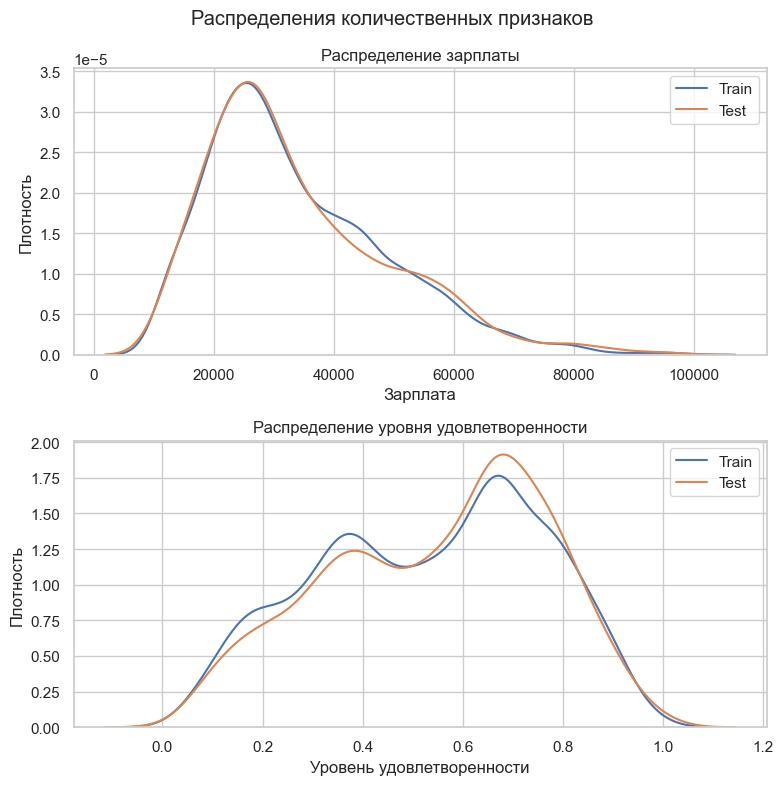

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axes = axes.flatten()

title = [['Распределение зарплаты', 'Зарплата', 'Плотность'],
         ['Распределение уровня удовлетворенности', 'Уровень удовлетворенности', 'Плотность']
        ]

# строим графики
for ax, col, title in zip(axes, num_column_list, title):
    sns.kdeplot(data=train_job,
                x=col,
                palette='mako',
                ax=ax,
                label='Train'
                )
    sns.kdeplot(data=test_features.join(test_target_job),
                x=col,
                palette='mako',
                ax=ax,
                label='Test'
                )

    show_title(title=title[0],
           x_label=title[1],
           y_label=title[2],
           ax=ax)
    
    ax.legend()
    
    
fig.suptitle('Распределения количественных признаков')
plt.tight_layout()
plt.show()

- ***Средняя зарплата около 30000.***
- ***Уровень удовлетворенности имеет 2 пика около 0.5 и 0.8.***
- ***Распределения зарплаты на тренировочной и тестовых выборках практически совпадают.***
- ***Распределения таргета на тестовой и тренировочной выборках близки.***

#### Диаграммы разброса

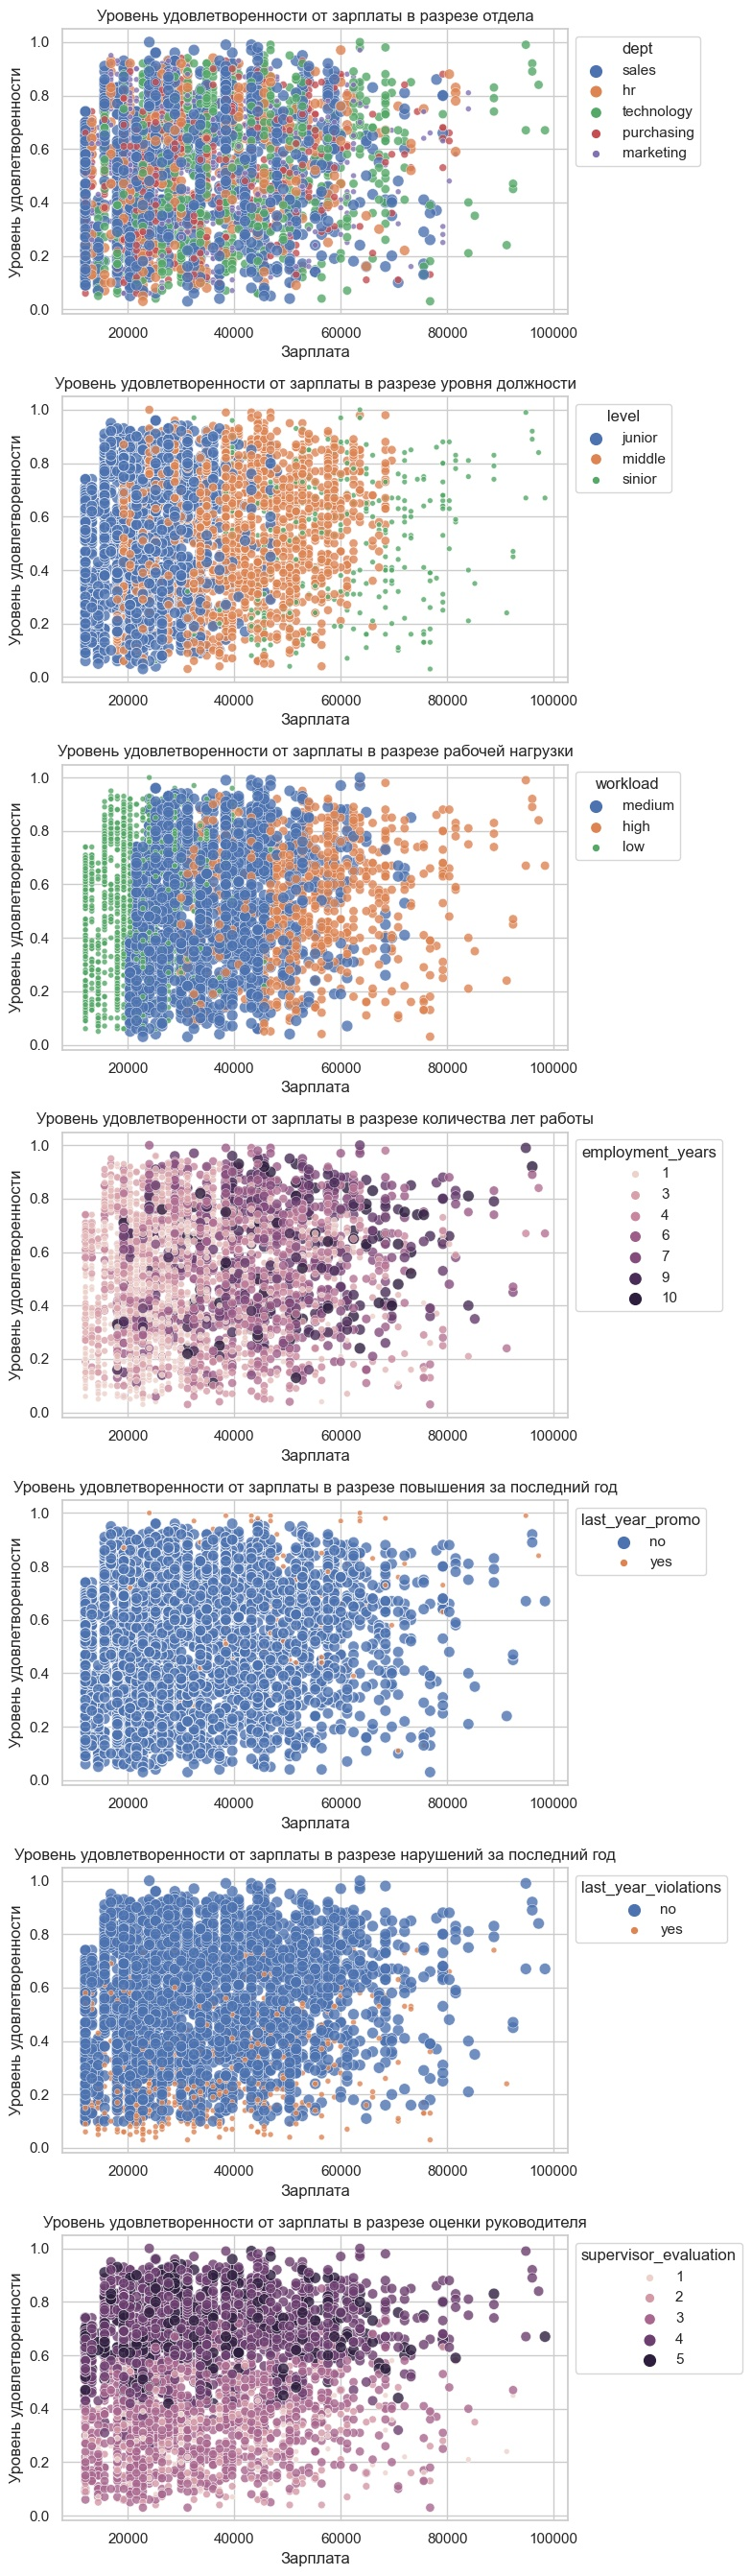

In [18]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 27))
axes = axes.flatten()

title = ['Уровень удовлетворенности от зарплаты в разрезе отдела',
        'Уровень удовлетворенности от зарплаты в разрезе уровня должности',
        'Уровень удовлетворенности от зарплаты в разрезе рабочей нагрузки',
        'Уровень удовлетворенности от зарплаты в разрезе количества лет работы',
        'Уровень удовлетворенности от зарплаты в разрезе повышения за последний год',
        'Уровень удовлетворенности от зарплаты в разрезе нарушений за последний год',
        'Уровень удовлетворенности от зарплаты в разрезе оценки руководителя']

for ax, hue, title in zip(axes, cat_column_list, title):
    sns.scatterplot(data=train_job,
                    x='salary',
                    y='job_satisfaction_rate',
                    hue=hue,
                    size=hue,
                    alpha=0.8,
                    ax=ax)
    #легенда
    ax.legend(title=hue, bbox_to_anchor=(1, 1))
    #подписи
    show_title(title=title,
           x_label='Зарплата',
           y_label='Уровень удовлетворенности',
           ax=ax)
    
plt.tight_layout()
plt.show()

#### Категориальные признаки
- **Построим графики распределения категориальных признаков тренировочной и тестовой выборок.**

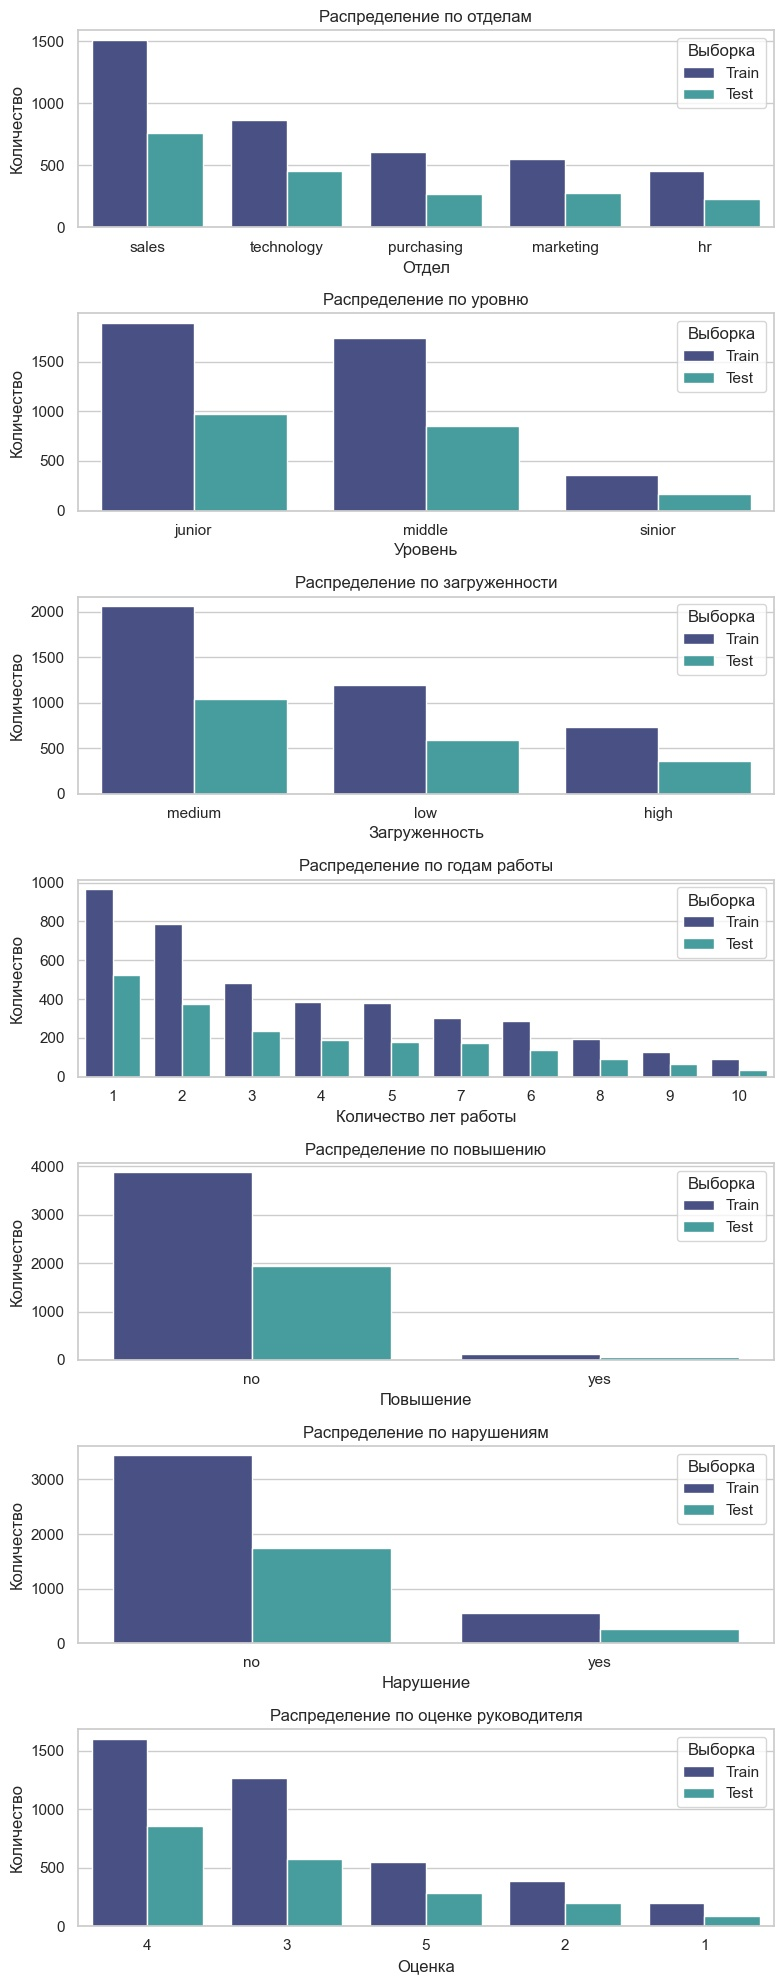

In [19]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 20))
axes = axes.flatten()

title = [['Распределение по отделам', 'Отдел'], 
        ['Распределение по уровню', 'Уровень'],
        ['Распределение по загруженности', 'Загруженность'],
        ['Распределение по годам работы', 'Количество лет работы'],
        ['Распределение по повышению', 'Повышение'],
        ['Распределение по нарушениям', 'Нарушение'],
        ['Распределение по оценке руководителя', 'Оценка']]

# создаем временные массивы с категориальными признаками и объединяем в один
train_tmp = train_job[cat_column_list].copy()
train_tmp['Выборка'] = 'Train'
test_tmp = test_features[cat_column_list].copy()
test_tmp['Выборка'] = 'Test'

comb = pd.concat([train_tmp, test_tmp], axis=0)

# строим графики
for ax, col, title in zip(axes, cat_column_list, title):
    sns.countplot(data=comb,
                 x=col,
                 palette='mako',
                 order=train_job[col].value_counts().index,
                 hue='Выборка',
                 ax=ax
                )
    
    # подписи графиков
    show_title(title=title[0],
               x_label=title[1],
               y_label='Количество',
               ax=ax)  

plt.tight_layout()
plt.show()

- ***По диаграммам видно, что категориальные признаки в тестовой и тренировочной выборках распределены похожим образом. Сильных отличий, которые могли бы повлиять на предсказание нет.***

### Корреляционный анализ
- **Проведем анализ корреляции признаков.**

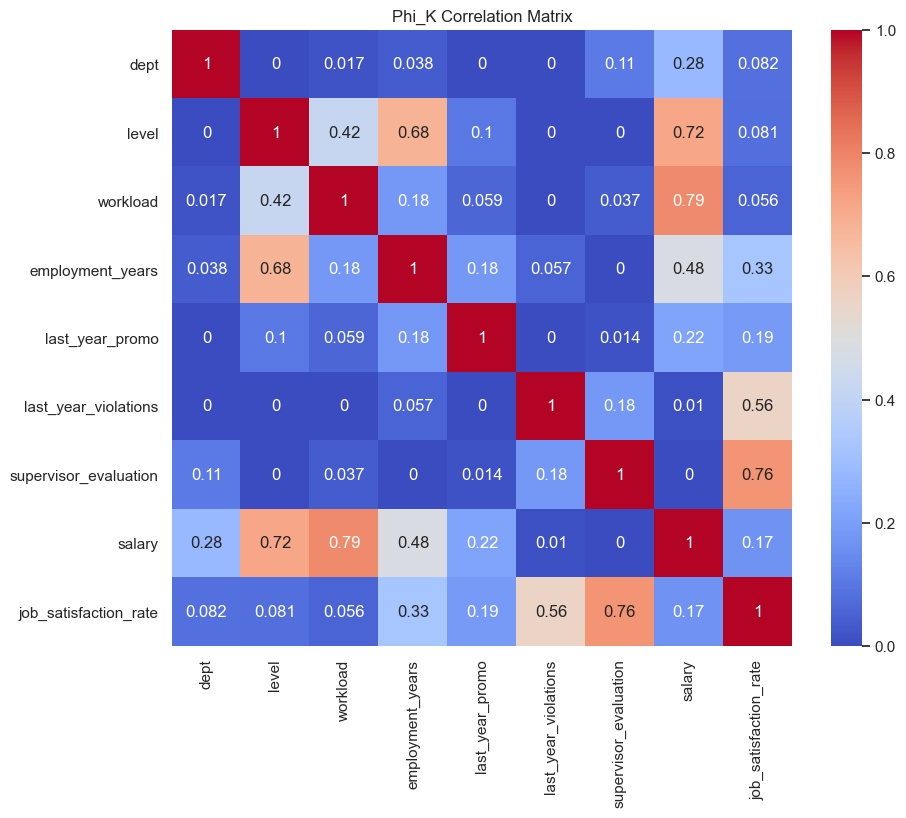

In [20]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = train_job.phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

- **Анализ корреляции тестовой выборки.**

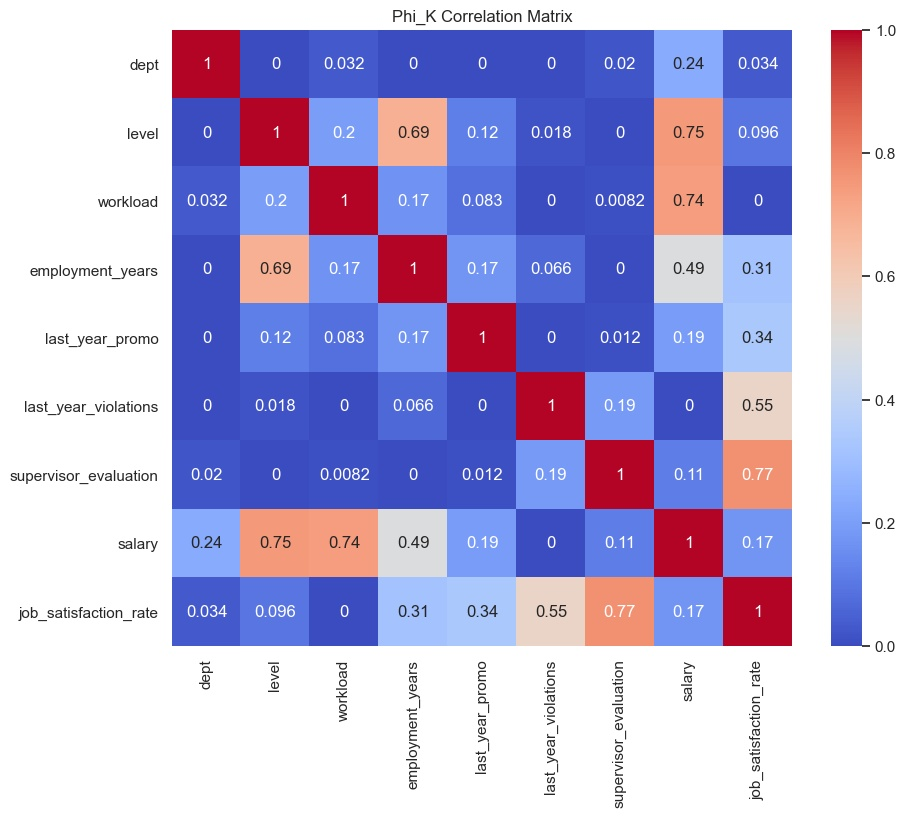

In [21]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = (test_features
               .join(test_target_job)
               .phik_matrix(interval_cols=['job_satisfaction_rate', 'salary']))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

- ***Оценка руководителя коррелирует с уровнем удовлетворенности (0.76).***
- ***Так же умеренная корреляция между зарплатой и загруженностью, зарплатой и уровнем работника.***
- ***Корреляция признаков на тренировочной выборке аналогична корреляции на тестовой выборке.***

### Вывод по EDA


- ***Линейной зависимости уровня удовлетворенности от зарплаты не наблюдается.***
- ***Среди работников разного уровня загруженности, разного опыта, и разных отделов уровень удовлетворенности распределен так же нелинейно.***
- ***Количество сотрудников, укоторых было повышение крайне мало относительно всей выборки, но видно, что их уровень удовлетворенности чаще высокий.***
- ***Наоборот, для сотрудников с нарушениями чаще встречается большая неудовлетворенность работой.***
- ***У сотрудника с низкой оценкой руководителя чаще более низкий уровень удовлетворенности.***

---

- ***Чаще встречаются сотрудники с высоким уровнем загрузки, уровня junior и middle.***
- ***Практически все сотрудники без повышения за последний год.***
- ***Средняя оценка руководителя - 4.***

---

- ***Распределения количественных и категориальных признаков на тренировочной и тестовой выборках аналогичны. Матрицы корреляции аналогичны.***

---

- ***Подготовка признаков:***
    - ***Для количественных переменных будем использовать MinMaxScaler или StandardScaler.***
    - ***Столбцы `workload, level` закодируем OrdinalEncoder с указанием порядка.***
    - ***Столбцы `dept, last_year_promo, last_year_violations` закодируем OHE.***
    - ***Столбцы `supervisor_evaluation, employment_years` кодировать не требуется. Там содержатся значения int по сути уже ранжированные.***
    

<a id="pipeline1"></a>
## Подготовка данных

In [22]:
def make_pipeline(df, ohe_columns, ord_columns, categories):

    '''
    Функция готовит пайплпйн
    '''

    X_train = df.drop(['job_satisfaction_rate'], axis=1)
    y_train = df['job_satisfaction_rate']

    # выделяем признаки для кодирования
    num_columns = X_train.columns[X_train.nunique() >= 20].tolist()
    ohe_columns = ohe_columns 
    ord_columns = ord_columns 

    # категории
    categories = categories

    # для бинарных признаков
    ohe_pipe = Pipeline(
        [('SimpleImputer_before_ohe', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
    )

    # для номинальных признаков
    ord_pipe = Pipeline(
        [('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=categories,
                            handle_unknown='use_encoded_value',
                            unknown_value=np.nan
                            ))
        ]
    )

    # для количественных признаков
    num_pipe = Pipeline(
        [('imputer', SimpleImputer(strategy='mean')),
        ('num', MinMaxScaler())
        ]
    )

    # для обработки всех признаков
    preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

    # финальный пайплайн
    pipe_final = Pipeline(
        [('preprocessor', preprocessor),
        ('models', LinearRegression())]
    )

    return pipe_final, X_train, y_train, preprocessor

In [23]:
# задаем список моделей и гиперпараметров
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

<a id="model1"></a>
## Обучение модели

### Метрика SMAPE

In [24]:
def smape(y_true, y_pred):
    
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    if len(y_true) == len(y_pred):
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    else:
        print('Размеры выборок не совпадают')

In [25]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Обучение

In [26]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

categories = [['junior', 'middle', 'sinior'],
             ['low', 'medium', 'high']]

pipe_final, X_train, y_train, preprocessor = make_pipeline(train_job, ohe_columns, ord_columns, categories)

search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    n_iter=250
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations',
                                                                                'dept']),
                                                                              ('o...
                                         'models__max_depth': range(2, 15),
                                         'models__max_features': range(2, 15),
                                         'models__min_samples_leaf': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

### Лучшая модель

In [27]:
pipe_final_best = Pipeline(
    [('preprocessor', preprocessor),
     ('models', search.best_estimator_['models'])]
)

pipe_final_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImpute...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=14, max_features=12,
                                       min_samples_leaf=3, random_state=42))])

In [28]:
print(f'SMAPE лучшей модели на кросс-валидации: {-search.best_score_:.2f}')

SMAPE лучшей модели на кросс-валидации: 14.28


- **Поочередно удалим столбцы с высокой корреляцией из датафрейма и исследуем их влияние:**

In [29]:
def columns_drop_analyze(df, ord_columns_choise, category_map):
    '''
    Функция поочередного удаления указанных столбцов
    '''
    for ord_col in ord_columns_choise:
    
        drop_cols = ['job_satisfaction_rate'] + [col for col in category_map if col not in ord_col]
        X_train = df.drop(columns=drop_cols, axis=1)
        y_train = df['job_satisfaction_rate']
        
        # выделяем признаки для кодирования
        
        ord_columns = ord_col
        num_columns = X_train.columns[X_train.nunique() >= 20].tolist()

        # категории
        categories = [category_map[col] for col in ord_col]        

        # для номинальных признаков
        ord_pipe = Pipeline(
            [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('ord', OrdinalEncoder(categories=categories,
                                handle_unknown='use_encoded_value',
                                unknown_value=np.nan)),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
            ]
        )

        # для бинарных признаков
        ohe_pipe = Pipeline(
        [('SimpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
        )

        # для количественных признаков
        num_pipe = Pipeline(
        [('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
        ('num', MinMaxScaler())]
        )

        # для обработки всех признаков
        preprocessor = ColumnTransformer(
            [('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', num_pipe, num_columns)
            ],
            remainder='passthrough'
        )

        # финальный пайплайн
        pipe_final = Pipeline(
            [('preprocessor', preprocessor),
            ('models', LinearRegression())]
        )

        search = RandomizedSearchCV(
            pipe_final,
            param_grid,
            cv=5,
            scoring=smape_scorer,
            n_jobs=-1,
            n_iter=50
        )

        search.fit(X_train, y_train)

        print(f"Выбор колонок: {ord_col} — Лучшая SMAPE на тренировочной выборке: {-search.best_score_:.4f}")

In [30]:
# список столбцов, которые остаются в датафрейме
ord_columns_choise = [['level', 'workload'],
                    ['level'],
                    ['workload'],
                    []]
# словарь значений признаков для OrdinalEncoder
category_map = {
    'level': ['junior', 'middle', 'sinior'],
    'workload': ['low', 'high', 'medium']
}

columns_drop_analyze(train_job, ord_columns_choise, category_map)

Выбор колонок: ['level', 'workload'] — Лучшая SMAPE на тренировочной выборке: 14.4933
Выбор колонок: ['level'] — Лучшая SMAPE на тренировочной выборке: 14.9576
Выбор колонок: ['workload'] — Лучшая SMAPE на тренировочной выборке: 16.2119
Выбор колонок: [] — Лучшая SMAPE на тренировочной выборке: 16.9603


- ***При удалении столбцов с высокой корреляцией качество метрики ухудшается. Оставим их.***

In [31]:
def residuals_analyze(y_test, predictions):
    '''
    Функция для находжения остатков. Построения Гистограммы и диаграммы разброса.
    '''

    y_test = np.array(y_test).reshape(-1)
    predictions = np.array(predictions).reshape(-1)

    y_test, predictions = np.array(y_test), np.array(predictions)
    # ощем остатки
    residuals = y_test - predictions
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
    sns.histplot(residuals, ax=axes[0], color='seagreen', edgecolor='black')
    
    show_title(title='Гистограмми распределения остатков',
                   x_label='Остатки',
                   y_label='',
                   ax=axes[0])
    
    sns.residplot(x=predictions, y=residuals, ax=axes[1], color='seagreen', lowess=True, line_kws=dict(color="r"))
    
    show_title(title='Анализ дисперсии',
                   x_label='Предсказания модели',
                   y_label='Остатки',
                   ax=axes[1])
    plt.show()

### Анализ остатков модели
- **Проанализируем остатки модели:**

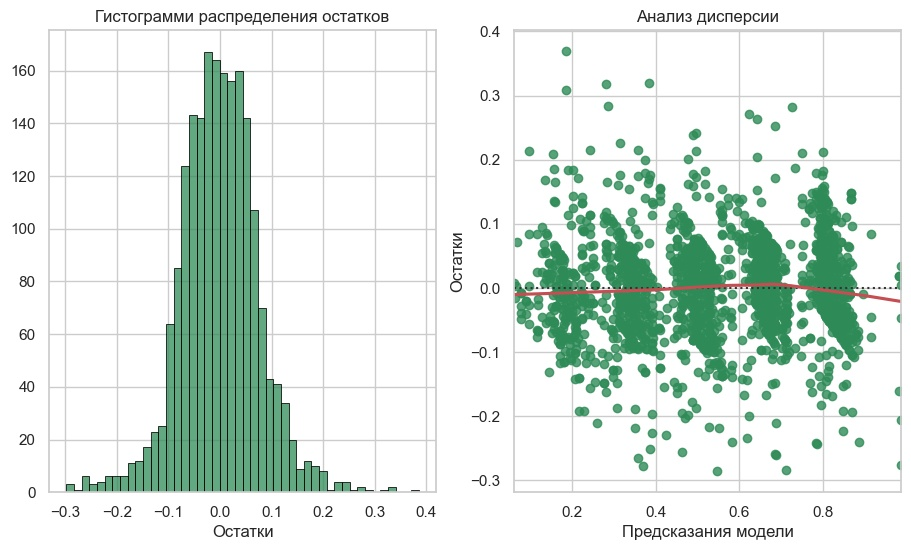

In [32]:
residuals_analyze(test_target_job, pipe_final_best.predict(test_features))

- ***Гистограмма распределения остатков близка к нормальной. Смещения нет. Разброс дисперсии выглядит не совсем однородным.***

### Новые признаки
- **Введем новые признаки, проведем анализ их влияния на предсказания модели.**

In [33]:
def add_new_features(df):
    df_new = df.copy()
    
    #добавим столбец с логарифмом от ЗП
    df_new['log_salary'] = df_new['salary'].apply(np.log) 
    
    #добавим столбец 'отношение лог зарплаты к длительности работы в компании'
    df_new['salary_per_year'] = df_new['salary'] / df_new['employment_years']
    
    #добавим столбец 'произведение зарплаты на оценку руководителя'
    df_new['salary_eval'] = df_new['salary'] * df_new['supervisor_evaluation']
    
    #добавим столбец 'отношение зарплаты к средней зарплате по отделу'
    df_new['salary_vs_dept'] = df_new['salary'] / df_new.groupby('dept')['salary'].transform('mean')
    
    #добавим столбец 'отношение зарплаты к средней зарплате по уровню'
    df_new['salary_vs_level'] = df_new['salary'] / df_new.groupby('level')['salary'].transform('mean')
    
    #добавим столбец 'отношение зарплаты к средней зарплате по уровню загруженности'
    df_new['salary_vs_workload'] = df_new['salary'] / df_new.groupby('workload')['salary'].transform('mean')
    
    #добавим столбец 'отношение оценки к средней оценке по уровню загруженности'
    df_new['eval_vs_workload'] = (df_new['supervisor_evaluation'] / df_new.groupby('workload')['supervisor_evaluation']
                                  .transform('mean'))
    
    return df_new

In [34]:
train_job_new = add_new_features(train_job)
test_features_new = add_new_features(test_features)

train_job_new.shape, test_features_new.shape

((4000, 16), (2000, 15))

In [35]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

categories = [['junior', 'middle', 'sinior'],
             ['low', 'medium', 'high']]


pipe_final_new, X_train_new, y_train, preprocessor_new = make_pipeline(train_job_new,
                                                                       ohe_columns,
                                                                       ord_columns,
                                                                       categories)

search_new = RandomizedSearchCV(
    pipe_final_new,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    n_iter=250
)

search_new.fit(X_train_new, y_train)

pipe_final_best_new = Pipeline(
    [('preprocessor', preprocessor_new),
     ('models', search_new.best_estimator_['models'])]
)

pipe_final_best_new.fit(X_train_new, y_train)

print(f"Лучшая SMAPE на тренировочной выборке: {-search_new.best_score_:.2f}")

Лучшая SMAPE на тренировочной выборке: 14.65


### Анализ важности признаков

In [36]:
def shap_plot(shap_values, X_test_transformed):
    
    """
    Функция строит SHAP и добавляет подписи осей
    """
    
    shap.summary_plot(shap_values, X_test_transformed, show=False)

    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_xlabel("SHAP значение (влияние на предсказание)", fontsize=12)
    ax.set_ylabel("Признаки", fontsize=16)
    ax.set_title("Влияние признаков на предсказания модели", fontsize=16, pad=20)

    cb_ax = fig.axes[1] 

    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel("Значение признака", fontsize=16)

    plt.show()

In [37]:
# оценка важности признаков
X_test_transformed = pd.DataFrame(pipe_final_best_new.named_steps['preprocessor'].transform(test_features_new),
                                   columns=pipe_final_best_new.named_steps['preprocessor'].get_feature_names_out())


explainer = shap.Explainer(pipe_final_best_new.named_steps['models'].predict,
    X_test_transformed,
    feature_names=X_test_transformed.columns)
shap_values = explainer(X_test_transformed)

shap_values.shape, X_test_transformed.shape

PermutationExplainer explainer: 2001it [01:13, 24.90it/s]                          


((2000, 18), (2000, 18))

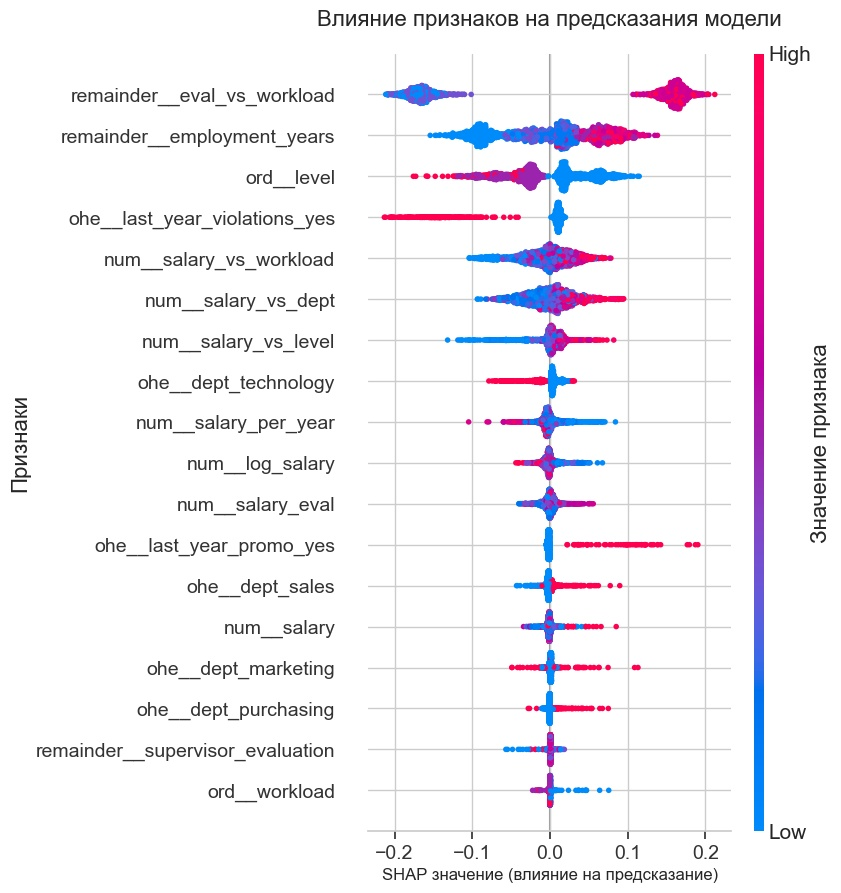

In [38]:
shap_plot(shap_values, X_test_transformed)

- ***Из всех введенных признаков наибольшую важность имеет `eval_vs_workload`. Добавим только его к исходным данным и проверим метрику SMAPE:***

In [39]:
def add_new_feature_eval(df):
    df_new = df.copy()
    
    #добавим столбец 'отношение оценки к средней оценке по уровню загруженности'
    df_new['eval_vs_workload'] = (df_new['supervisor_evaluation'] / df_new.groupby('workload')['supervisor_evaluation']
                                  .transform('mean'))
    
    return df_new

In [40]:
train_job_new1 = add_new_feature_eval(train_job)

test_features_new1 = add_new_feature_eval(test_features)


pipe_final_new, X_train_new, y_train, preprocessor_new = make_pipeline(train_job_new1,
                                                                       ohe_columns,
                                                                       ord_columns,
                                                                       categories)

search_new = RandomizedSearchCV(
    pipe_final_new,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    n_iter=250
)

search_new.fit(X_train_new, y_train)

pipe_final_best_new = Pipeline(
    [('preprocessor', preprocessor_new),
     ('models', search_new.best_estimator_['models'])]
)

pipe_final_best_new.fit(X_train_new, y_train)

print(f"Лучшая SMAPE на тренировочной выборке с 1 дополнительным признаком: {-search.best_score_:.2f}")

Лучшая SMAPE на тренировочной выборке с 1 дополнительным признаком: 14.28


- ***С введением признака `eval_vs_workload` улучшение метрики не произошло.***

- **Оценим важность признаков исходной выборки без дополнительных признаков, на которой была максимальная метрика SMAPE.**

In [41]:
# оценка важности признаков
X_test_transformed = pd.DataFrame(pipe_final_best.named_steps['preprocessor'].transform(test_features),
                                   columns=pipe_final_best.named_steps['preprocessor'].get_feature_names_out())


explainer = shap.Explainer(pipe_final_best.named_steps['models'].predict,
    X_test_transformed,
    feature_names=X_test_transformed.columns)
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 2001it [01:37, 18.56it/s]                          


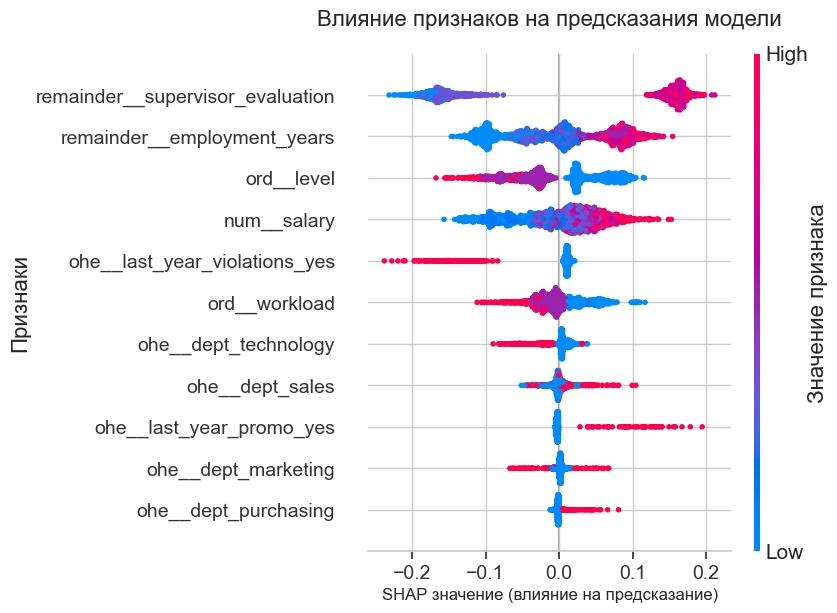

In [42]:
shap_plot(shap_values, X_test_transformed)

### SMAPE на лучшей модели 

In [43]:
# оценка SMAPE на тестовой выборке
print(f"SMAPE на тестовой выборке: {smape(test_target_job, pipe_final_best.predict(test_features)):.3f}")

SMAPE на тестовой выборке: 13.659


<a id="conclusion1"></a>
## Промежуточные выводы

- ***По результатам моделирования выбрана модель `DecisionTreeRegressor(max_depth=14, max_features=13, min_samples_leaf=3, random_state=42)`.***
- ***В данной задаче лучшей оказалась модель решающего дерева, т.к. нет линейных связей между признаками и таргетом, поэтому линейная модель не смогла показать хороший результат.***
- ***Метрика SMAPE на тестовой выборке 13.6.***
- ***Был проведен подбор параметров и введены новые признаки, но улучшить модель с их помощбю не удалось.***

- ***Анализ важности признаков показал, что:***

    - ***Оценка руководителя сильнее всего влияет на уровень удовлетворенности сотрудника.***
    - ***Чем дольше сотрудник работает в компании, тем его удовлетворенность выше.***
    - ***Высокие зарплаты влияют на удовлетворенность в меньшей степени.***

<a id="task2"></a>
# Задача 2

**Необходимо построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании**

<a id="load2"></a>
## Обзор данных

 
Данные, предоставленные заказчиком имеют следующие признаки:  

- **id** — уникальный идентификатор сотрудника;  
- **dept** — отдел, в котором работает сотрудник;  
- **level** — уровень занимаемой должности;  
- **workload** — уровень загруженности сотрудника;  
- **employment_years** — длительность работы в компании (в годах);  
- **last_year_promo** — было ли повышение за последний год;  
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;  
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;  
- **salary** — ежемесячная зарплата сотрудника;  
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.
#### Задача 2:
##### Файл `train_quit.csv` - тренировочная выборка.

##### Файл `test_features.csv` - входные признаки тестовой выборки.

##### Файл `test_target_quit.csv` - целевой признак тестовой выборки.

### Загрузка датасетов

In [44]:
# загружаем датасеты
pth4 = '/datasets/train_quit.csv'
pth4_alt = r"C:\Users\User\da_practicum\local_projects\8 Сборный проект 2\data\train_quit.csv"
pth5 = '/datasets/test_target_quit.csv'
pth5_alt = r"C:\Users\User\da_practicum\local_projects\8 Сборный проект 2\data\test_target_quit.csv"

dataframes = []

pth = [pth4, pth5]

pth_alt = [pth4_alt, pth5_alt]

for pth, pth_alt in zip(pth, pth_alt):

    if os.path.exists(pth):
        df = pd.read_csv(pth, index_col='id')
    elif os.path.exists(pth_alt):
        df = pd.read_csv(pth_alt, index_col='id')
    else:
        print('Something is wrong')
        df = None

    dataframes.append(df)

train_quit, test_target_quit = dataframes
# проверка
train_quit.shape, test_target_quit.shape

((4000, 9), (2000, 1))

### Датасет train_quit

In [45]:
displ(train_quit)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


,count,mean,std,min,25%,50%,75%,max
employment_years,4000.00,3.70,2.54,1.00,2.00,3.00,6.00,10.00
supervisor_evaluation,4000.00,3.47,1.00,1.00,3.00,4.00,4.00,5.00
salary,4000.00,33805.80,15152.42,12000.00,22800.00,30000.00,43200.00,96000.00


,count,unique,top,freq
dept,4000,5,sales,1438
level,4000,3,junior,1949
workload,4000,3,medium,2118
last_year_promo,4000,2,no,3887
last_year_violations,4000,2,no,3455
quit,4000,2,no,2872


### Датасет test_target_quit

In [46]:
displ(test_target_quit)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


,count,unique,top,freq
quit,2000,2,no,1436


,count,unique,top,freq
quit,2000,2,no,1436


### Вывод по обзору:
- ***В целом, данные соответствубт описанию. Явных выбросов и аномалий нет.***
- ***В датасетах test_features и test_target_quit несовпадают id по порядку.***

<a id="data_preprocessing2"></a>
## Предобработка

### Проверка на дубликаты

In [47]:
# проверим полные дубли
check_dupl(train_quit)

Количество полных дубликатов: 0


In [48]:
# проверим уникальные значения каатегориальных признаков
print('Датасет train_quit:')
check_implicit_dupl(train_quit)

Датасет train_quit:
dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr'] количество уникальных значений: 5 

level : ['middle' 'junior' 'sinior'] количество уникальных значений: 3 

workload : ['high' 'medium' 'low'] количество уникальных значений: 3 

last_year_promo : ['no' 'yes'] количество уникальных значений: 2 

last_year_violations : ['no' 'yes'] количество уникальных значений: 2 

quit : ['no' 'yes'] количество уникальных значений: 2 



### Упорядочивание test_target_quit

In [49]:
# упорядочим test_target_quit в соответствии с индексами test_features
test_target_quit = test_features.join(test_target_quit)[['quit']]
test_target_quit

,quit
id,
485046,no
686555,no
467458,no
418655,no
789145,no
...,...
393147,yes
109582,yes
305653,yes


### Вывод по предобработке:
- ***В датасете train_quit пропусков, дубликатов нет.***
- ***Упорядочили test_target_quit в соответствии с индексами test_features.***

<a id="eda2"></a>
## Исследовательский анализ

### Построение графиков
#### Категориальные признаки:
- **Построим графики распределения категориальных признаков и изучим их зависимость от таргета.**

In [50]:
# выделим количественные и категориальные признаки
cl_num_column_list = train_quit.columns[train_quit.nunique() >= 20].tolist()
cl_cat_column_list = train_quit.columns[train_quit.nunique() < 20].tolist()
cl_num_column_list, cl_cat_column_list

(['salary'],
 ['dept',
  'level',
  'workload',
  'employment_years',
  'last_year_promo',
  'last_year_violations',
  'supervisor_evaluation',
  'quit'])

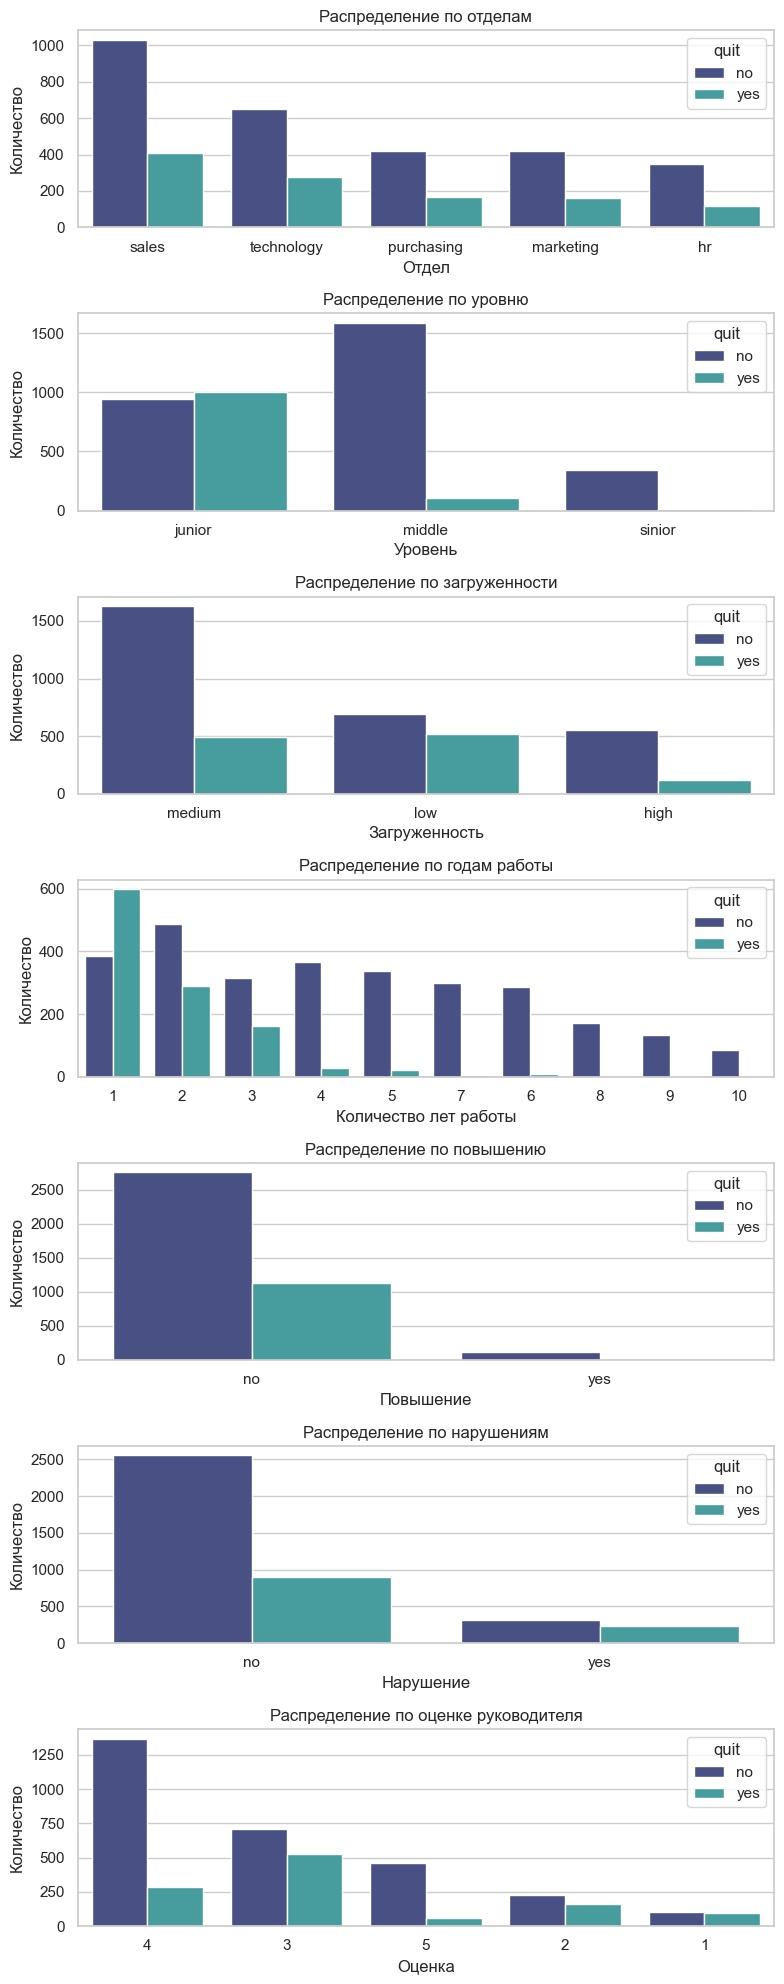

In [51]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 20))
axes = axes.flatten()

title = [['Распределение по отделам', 'Отдел'], 
        ['Распределение по уровню', 'Уровень'],
        ['Распределение по загруженности', 'Загруженность'],
        ['Распределение по годам работы', 'Количество лет работы'],
        ['Распределение по повышению', 'Повышение'],
        ['Распределение по нарушениям', 'Нарушение'],
        ['Распределение по оценке руководителя', 'Оценка']]

# строим графики
for ax, col, title in zip(axes, cl_cat_column_list, title):
    sns.countplot(data=train_quit,
                 x=col,
                 palette='mako',
                 hue='quit',
                 order=train_quit[col].value_counts().index,
                 ax=ax
                )
    
    # подписи графиков
    show_title(title=title[0],
               x_label=title[1],
               y_label='Количество',
               ax=ax)  

plt.tight_layout()
plt.show()

- ***Распределение уволившихся сотрудников по отделам совпадает с общим распределением.***
- ***Практически все уволившиеся сотрудники уровня junior. Так же это видно по графику с годами работы - почти все уволившиеся проработали 1-3 года. Чем дольше сотрудник работает в компании, тем меньше шанс его ухода. В компании возможна недостаточная поддержка начинающих специалистов, заказчику стоит обратить на это внимание.***
- ***Чаще увольняются сотрудники со средним уровнем загруженности.***
- ***Сотрудники с высокой оценкой руководителся (4-5) увольняются реже, чем с низкой (3-1).***

#### Количественный признак

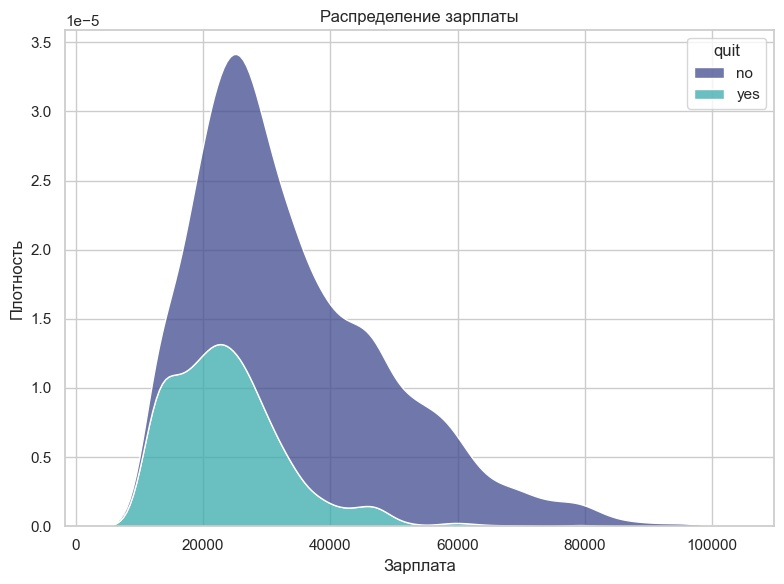

In [52]:
title = ['Распределение зарплаты', 'Зарплата', 'Плотность']

# строим график
ax = sns.kdeplot(data=train_quit,
            x='salary',
            palette='mako',
            hue='quit',
            multiple='stack'
            )

show_title(title=title[0],
       x_label=title[1],
       y_label=title[2],
       ax=ax)

plt.tight_layout()
plt.show()

- ***По графику распределения зарплаты видно, что у уволившихся сотрудников она несколько ниже.***

### Корреляционный анализ
- **Проведем анализ корреляции признаков.**

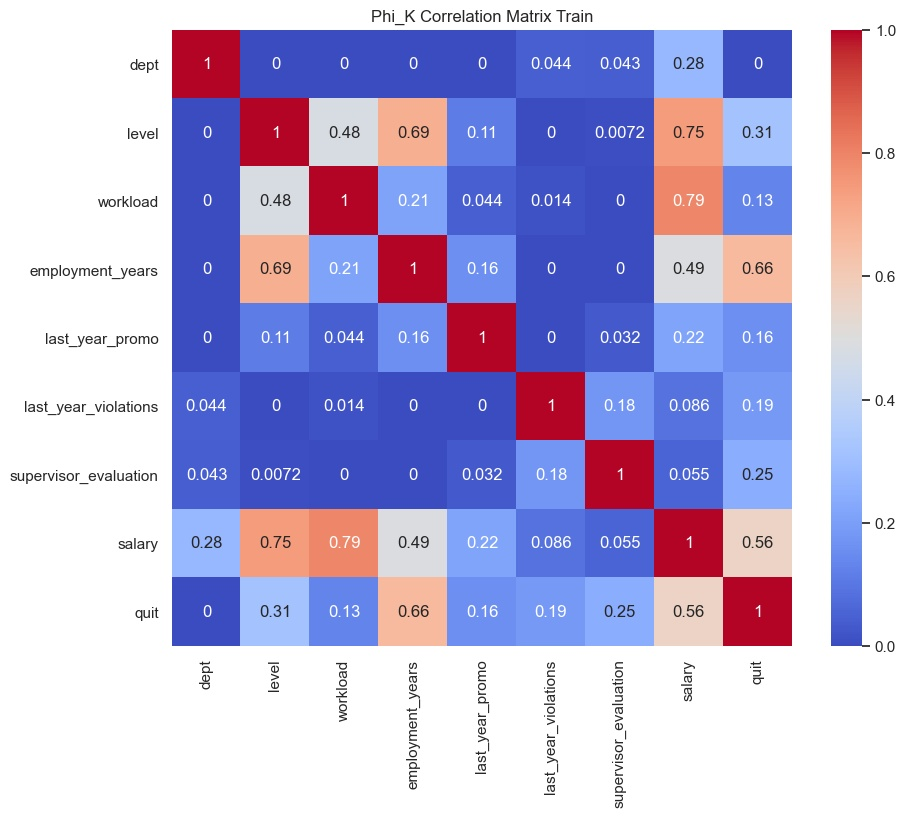

In [53]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = train_quit.phik_matrix(interval_cols=['salary'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix Train')
plt.show()

- ***Видим умеренные зависимости зарплаты от уровня сотрудника и от рабочей нагрузки.***
- ***Умеренные зависимости между годами работы и уровнем сотрудника, между таргетом и годами работы.***
- ***В данной задаче не будем удалять признаки с умеренной корреляцией. При получении неудовлетворительного значения целевой метрики на этапе кросс-валидации можно рассмотреть влияние умеренно-коррелирующих признаков и возможность их исключения.***

(Матрица корреляции для test_features была построена в первой задаче.)

### Портрет «уволившегося сотрудника»

- **Изучим средние значения времени работы, уровня зарплаты, оценки руководителя в зависимости от того остался сотрудник или уволился.**

In [54]:
pivot = pd.pivot_table(train_quit, columns=['quit'], aggfunc='mean')
pivot['изменение_в_процентах'] = (pivot['yes'] - pivot['no']) / pivot['no'] * 100
pivot.style.background_gradient(subset='изменение_в_процентах', cmap='coolwarm')

quit,no,yes,изменение_в_процентах
employment_years,4.430710,1.844858,-58.362023
salary,37702.228412,23885.106383,-36.648025
supervisor_evaluation,3.643106,3.046099,-16.387297


- ***Среднее количество лет работы у уволившегося сотрудника на 58% меньше.***
- ***Средняя зарплата уволившегося сотрудника на 37% меньше.***
- ***Средняя оценка руководителя уволившегося сотрудника на 16% меньше.***

- ***Изучим процент уволившихся сотрудников по отделам и уровню загруженности.***

In [55]:
pivot_dept = pd.pivot_table(train_quit, index=['dept', 'workload'], columns='quit', values='salary', aggfunc=['size', 'mean'])
pivot_dept.columns = ['no', 'yes', 'mean_no', 'mean_yes']

pivot_dept['процент_уволившихся'] = pivot_dept['yes'] / (pivot_dept['yes'] + pivot_dept['no']) * 100
pivot_dept['изменение_зарплаты_в_процентах'] = (pivot_dept['mean_yes'] - pivot_dept['mean_no']) / pivot_dept['mean_no'] * 100
(pivot_dept
 .sort_values(by='процент_уволившихся', ascending=False).sort_index()
 .style
 .format('{:.2f}')
 .background_gradient(subset=['процент_уволившихся', 'изменение_зарплаты_в_процентах'], cmap='coolwarm'))

In [56]:
pivot_level = pd.pivot_table(train_quit, index=['level'], columns='quit', aggfunc=['size'])
pivot_level.columns = ['no', 'yes']
pivot_level['процент_уволившихся'] = pivot_level['yes'] / (pivot_level['yes'] + pivot_level['no']) * 100
(pivot_level
 .sort_values(by='процент_уволившихся', ascending=False).sort_index()
 .style
 .format('{:.2f}')
 .background_gradient(subset=['процент_уволившихся'], cmap='coolwarm'))


,no,yes,процент_уволившихся
level,,,
junior,946.00,1003.00,51.46
middle,1586.00,108.00,6.38
sinior,340.00,17.00,4.76


In [57]:
pivot_promo = pd.pivot_table(train_quit,
                             index=['last_year_promo'],
                             columns='quit',
                             aggfunc='size')
pivot_promo['процент_уволившихся'] = pivot_promo['yes'] / (pivot_promo['yes'] + pivot_promo['no']) * 100
pivot_promo

quit,no,yes,процент_уволившихся
last_year_promo,,,
no,2760,1127,28.99
yes,112,1,0.88


In [58]:
pivot_violations = pd.pivot_table(train_quit,
                             index=['last_year_violations'],
                             columns='quit',
                             aggfunc='size')
pivot_violations['процент_уволившихся'] = pivot_violations['yes'] / (pivot_violations['yes'] + pivot_violations['no']) * 100
pivot_violations

quit,no,yes,процент_уволившихся
last_year_violations,,,
no,2555,900,26.05
yes,317,228,41.83


- ***Максимальный процент уволившихся сотрудников в отделе HR. Эти сотрудники имеют низкий уровень загруженности.***
- ***В целом процент увольнений во всех отделах от 41 до 45.5% у сотрудников с низкой загрузкой. Сотрудники с высокой и средней загрузкой уходят значительно реже.***
- ***Причем видно, что колебания в средних зарплытах не такое значительное от уровня загрузки. Возможно у сотрудников недостаточно мотивации, им не ясна их роль и важность в компации***

- ***Итоговый портрет "уволившегося сотрудника":***    
    
    ***1. `Уровень должности`: 51% junior специалистов увольняются.***

    ***2. `Стаж работы`: большинство сотрудников уволились в течение 1–3 лет работы в компании.***

    ***3. `Уровень загрузки`: чаще всего увольняются сотрудники с низкой загрузкой, реже — с высокой или средней.***

    ***4. `Оценка руководителя`: сотрудники с оценкой 1–3 от руководителя увольняются чаще, чем с высокими оценками (4–5). средняя оценка от руководителя уволившегося на 16% ниже.***

    ***5. `Зарплата`: средняя зарплата уволившегося сотрудника на 37% ниже, чем у остающихся.***

    ***6. `Стаж работы`: стаж работы уволившегося сотрудника на 58% меньше.***

    ***7. `Отдел`: как правило чаще увольняются из HR отдела.***
    
    ***8. `Повышения`: уволившийся сотрудник работал без повышения последний год. 28% сотрудников из тех, кого не повысили уволились.***
    
    ***9. `Нарушения`: 42% уволившихся сотрудников как правило нарушали правила распорядка.*** 

---
- ***Распределение по отделам и загрузке:***

    - ***Отдел HR — максимальный процент увольнений.***

    - ***В этом отделе преобладают сотрудники с низкой загруженностью.***

    - ***Во всех отделах сотрудники с низкой загруженностью уходят в 41–45.5% случаев.***

    - ***При этом уровень зарплат почти не меняется в зависимости от загрузки — это может снижать мотивацию.***

### Влияние уровня удовлетворённости
- **Изучим влияние уровня удовлетворенности сотрудника работой в компании на то, уволится ли сотрудник.**

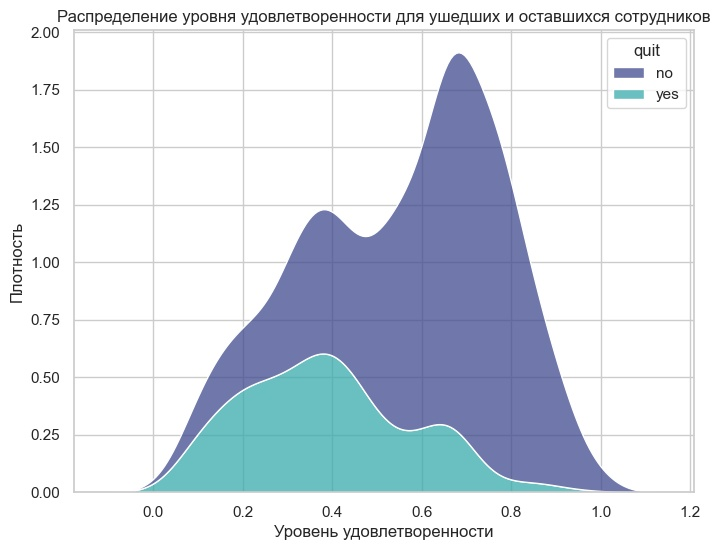

In [59]:
ax = sns.kdeplot(data=test_features.join([test_target_job, test_target_quit]),
                x='job_satisfaction_rate',
                palette='mako',
                multiple='stack',
                hue='quit'
            )

# подписи графиков
show_title(title='Распределение уровня удовлетворенности для ушедших и оставшихся сотрудников',
            x_label='Уровень удовлетворенности',
            y_label='Плотность',
            ax=ax) 

- ***По графику видно, что уровень удовлетворенности работой у уволившихся сотрудников в среднем ниже. Это может говорить о том, что уровень удовлетворенности работой оказывает влияние на то, уволится ли сотрудник.***

<a id="new_feature"></a>
## Добавление нового входного признака
- **Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.**

In [60]:
train_quit_new = train_quit.copy()
train_quit_new['job_satisfaction_rate'] = pipe_final_best.predict(train_quit_new.drop('quit', axis=1))
train_quit_new.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.65
814010,sales,junior,medium,2,no,no,4,27600,no,0.82
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.34
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.35
910140,marketing,junior,medium,2,no,no,5,25200,no,0.81


In [61]:
test_features_quit = test_features.copy()
test_features_quit['job_satisfaction_rate'] = pipe_final_best.predict(test_features_quit)
test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.88
686555,hr,junior,medium,1,no,no,4,30000,0.68
467458,sales,middle,low,5,no,no,4,19200,0.68
418655,sales,middle,low,6,no,no,4,19200,0.71
789145,hr,middle,medium,5,no,no,5,40800,0.81


<a id="pipeline2"></a>
## Подготовка данных

In [62]:
def make_pipeline_cl(df, ohe_columns, ord_columns, categories):

    '''
    Функция готовит пайплпйн
    '''

    X_train = df.drop(['quit'], axis=1)
    y_train = df['quit']

    #кодируем таргет
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)

    # выделяем признаки для кодирования
    num_columns = X_train.columns[X_train.nunique() >= 20].tolist()
    ohe_columns = ohe_columns 
    ord_columns = ord_columns 

    # категории
    categories = categories

    # для бинарных признаков
    ohe_pipe = Pipeline(
        [('SimpleImputer_before_ohe', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
    )

    # для номинальных признаков
    ord_pipe = Pipeline(
        [('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=categories,
                            handle_unknown='use_encoded_value', unknown_value=np.nan
                            )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ]
    )

    # для количественных признаков
    num_pipe = Pipeline(
        [('imputer', SimpleImputer(strategy='mean')),
        ('num', MinMaxScaler())
        ]
    )

    # для обработки всех признаков
    preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

    # финальный пайплайн
    pipe_final = Pipeline(
        [('preprocessor', preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))]
    )

    return pipe_final, X_train, y_train, preprocessor, label_encoder

In [63]:
# задаем список моделей и гиперпараметров
param_grid_cl = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, solver='saga')],
        'models__penalty': ['elasticnet'],
        'models__l1_ratio': np.linspace(0.01, 1, 10),
        'models__C': np.logspace(-3, 2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 150),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

]

<a id="model2"></a>
## Обучение модели
- **В данной задаче будем оптимизировать ROC-AUC.**

In [64]:
ohe_columns_cl = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_cl = ['level', 'workload']

categories = [['junior', 'middle', 'sinior'],
              ['low', 'medium', 'high']]

pipe_final_cl, X_train_cl, y_train_cl, preprocessor_cl, label_encoder = make_pipeline_cl(train_quit_new,
                                                                          ohe_columns_cl,
                                                                          ord_columns_cl,
                                                                          categories)

search_cl = RandomizedSearchCV(
    pipe_final_cl,
    param_grid_cl,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=250,
)

search_cl.fit(X_train_cl, y_train_cl)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('o...
                                         'models__l1_ratio': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                         'models__penalty': ['elasticnet'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(3, 150),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   scoring='roc_auc')

In [65]:
# лучшая модель
pipe_final_best_cl = Pipeline(
    [('preprocessor', preprocessor_cl),
     ('models', search_cl.best_estimator_['models'])]
)

pipe_final_best_cl.fit(X_train_cl, y_train_cl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImpute...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=7, max_features=7,
                                        min_samples_leaf=4, random_state=42))])

In [66]:
print(f'ROC-AUC лучшей модели на кросс-валидации: {search_cl.best_score_:.3f}')

ROC-AUC лучшей модели на кросс-валидации: 0.930


### ROC-AUC лучшей модели

In [67]:
# кодируем таргет
test_target_quit_tr = label_encoder.transform(test_target_quit)

# оценка ROC-AUC на тестовой выборке
roc_auc = roc_auc_score(test_target_quit_tr, pipe_final_best_cl.predict_proba(test_features_quit)[:,1])
print(f"ROC-AUC на тестовой выборке: {roc_auc:.3f}")

ROC-AUC на тестовой выборке: 0.921


- ***ROC-AUC на тестовых данных > 0.91. Модель успешно определяет уйдет ли сотрудник из компании.***

### Анализ важности признаков

In [68]:
# оценка важности признаков
X_test_transformed = pd.DataFrame(pipe_final_best_cl.named_steps['preprocessor'].transform(test_features_quit),
                                   columns=pipe_final_best_cl.named_steps['preprocessor'].get_feature_names_out())


explainer = shap.Explainer(pipe_final_best_cl.named_steps['models'].predict,
    X_test_transformed,
    feature_names=X_test_transformed.columns)
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 2001it [01:34, 18.98it/s]                          


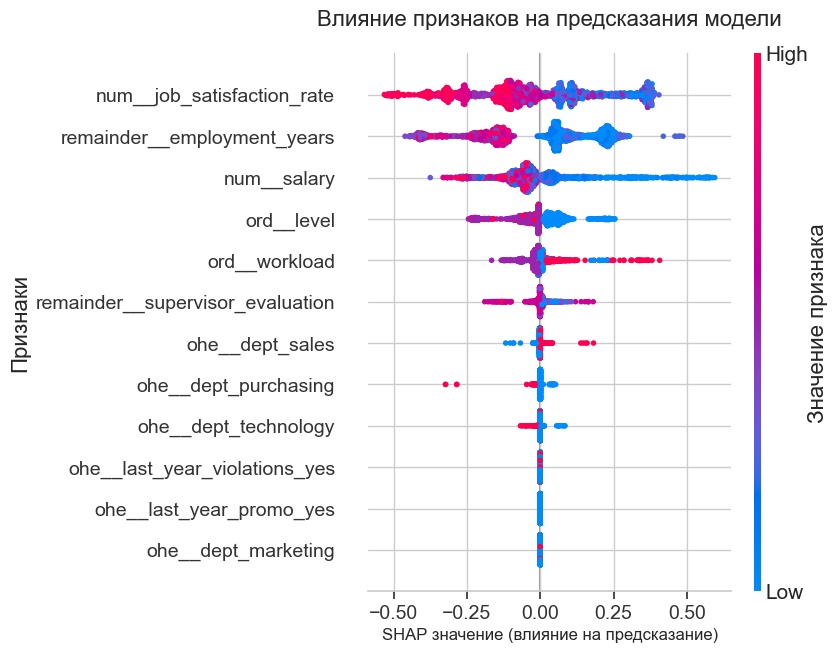

In [69]:
shap_plot(shap_values, X_test_transformed)

<a id="conclusion2"></a>
## Промежуточные выводы

- ***По результатам моделирования выбрана модель `DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42)`.***
- ***В данной задаче лучшей оказалась модель решающего дерева, т.к. нет линейных связей между признаками и таргетом, поэтому линейная модель не смогла показать хороший результат. KNN не смогла показать хороший результат, т.к. нет ярко выраженных разделенных кластеров данных. Категории смешаны друг с другом.***
- ***Метрика ROC-AUC на тестовой выборке 0.92.***

- ***Анализ важности признаков показал, что:***

    - ***Чем меньше удовлетворенность работой, тем вероятнее, что сотрудник уволится.***
    - ***С большей вероятностью уволится молодой сотрудник уровня junior.***
    - ***Так же увольняются сотрудники с более низким уровнем загруженности.***
    - ***С большей вероятностью уволится сотрудник с более низкой зарплатой.***

<a id="conclusion"></a>
# Общий вывод

***В данном проекте, направленном на исследование удовлетворенности работой сотрудников и на прогнозирование оттока сотрудников из компании, решалось 2 задачи:***
    
#### [Задача 1. Предсказать уровень удовлетворенности сотрудника.](#task1)
    
##### [1.1 Проведена предобработка данных, датасеты проверены на дубликаты, упорядочены значения таргета.](#data_preprocessing1)
    
##### [1.2 В результате EDA получены следующие данные:](#eda1)
- ***Линейной зависимости уровня удовлетворенности от зарплаты не наблюдается.***
- ***Среди работников разного уровня загруженности, разного опыта, и разных отделов уровень удовлетворенности распределен так же нелинейно.***
- ***Количество сотрудников, укоторых было повышение крайне мало относительно всей выборки, но видно, что их уровень удовлетворенности чаще высокий.***
- ***Наоборот, для сотрудников с нарушениями чаще встречается большая неудовлетворенность работой.***
- ***У сотрудника с низкой оценкой руководителя чаще более низкий уровень удовлетворенности.***
- ***Чаще встречаются сотрудники с высоким уровнем загрузки, уровня junior и middle.***
- ***Практически все сотрудники без повышения за последний год.***
- ***Средняя оценка руководителя - 4.***

##### [1.3 Проведена подготовка данных в pipeline, удалены пропуски, кодированы категориальные переменные, к числовым применены скейлеры.](#pipeline1)
##### [1.4 Проведено обучение модели:](#model1)
- ***Проведен подбор гиперпараметров с учетом минимизации метрики SMAPE.***
- ***Выбрана лучшая модель: `DecisionTreeRegressor(max_depth=14, max_features=14, min_samples_leaf=3, random_state=42)`***
- ***Лучшее значение метрики на тестовой выборке 13.613.***
- ***Проведен анализ остатков модели, изучена возможность улучшения модели за счет введения новых признаков и удаления малозначащих признаков. К улечшению метрики эти методы не привели. В итоге модель осталась с исходными признаками.***
##### 1.5 Выводы по задаче 1 и рекомендации для бизнеса:
| Закономерность                          | Рекомендации для бизнеса                                                                 |
|-----------------------------------------|------------------------------------------------------------------------------------------|
| **Оценка руководителя сильнее всего влияет на уровень удовлетворенности сотрудника** | 1. Пересмотреть систему оценки сотрудников.<br>2. Ввести KPI для руководителей, связанные с удовлетворенностью их сотрудников. |
| **Чем дольше сотрудник работает в компании, тем его удовлетворенность выше** | 1. Ввод системы поддержки молодых сотрудников.<br>2. Внедрение менторства и наставничества. |
| **Высокие зарплаты влияют на удовлетворенность в меньшей степени** | 1. Разработать системы нематериального поощрения сотрудников.<br>2. Внедрить программы признания заслуг. |

---

#### [Задача 2. Предсказать увольнение сотрудника.](#task2)

##### [1.1 Проведена предобработка данных, датасеты проверены на дубликаты, упорядочены значения таргета.](#data_preprocessing2)

##### [1.2 EDA.](#eda2)

- ***Составлен портрет уволившегося сотрудника***

    ***1. `Уровень должности`: 51% junior специалистов увольняются.***

    ***2. `Стаж работы`: большинство сотрудников уволились в течение 1–3 лет работы в компании.***

    ***3. `Уровень загрузки`: чаще всего увольняются сотрудники с низкой загрузкой, реже — с высокой или средней.***

    ***4. `Оценка руководителя`: сотрудники с оценкой 1–3 от руководителя увольняются чаще, чем с высокими оценками (4–5). средняя оценка от руководителя уволившегося на 16% ниже.***

    ***5. `Зарплата`: средняя зарплата уволившегося сотрудника на 37% ниже, чем у остающихся.***

    ***6. `Стаж работы`: стаж работы уволившегося сотрудника на 58% меньше.***

    ***7. `Отдел`: как правило чаще увольняются из HR отдела.***
    
    ***8. `Повышения`: уволившийся сотрудник работал без повышения последний год. 28% сотрудников из тех, кого не повысили уволились.***
    
    ***9. `Нарушения`: 42% уволившихся сотрудников как правило нарушали правила распорядка.*** 

- ***Распределение по отделам и загрузке:***

    - ***Отдел HR — максимальный процент увольнений.***

    - ***В этом отделе преобладают сотрудники с низкой загруженностью.***

    - ***Во всех отделах сотрудники с низкой загруженностью уходят в 41–45.5% случаев.***

    - ***При этом уровень зарплат почти не меняется в зависимости от загрузки — это может снижать мотивацию.***\

- ***Уровень удовлетворенности работой у уволившихся сотрудников в среднем ниже. Это может говорить о том, что уровень удовлетворенности работой оказывает влияние на то, уволится ли сотрудник.***

##### [1.3 Добавлен новый признак на основе предсказаний первой модели.](#new_feature)

##### [1.4 Проведена подготовка данных в pipeline, удалены пропуски, кодированы категориальные переменные, к числовым применены скейлеры.](#pipeline2)

##### [1.5 Проведено обучение модели:](#model2)

- ***По результатам моделирования выбрана модель `DecisionTreeClassifier(max_depth=5, max_features=9, min_samples_leaf=4, random_state=42)`.***
- ***В данной задаче лучшей оказалась модель решающего дерева, т.к. нет линейных связей между признаками и таргетом, поэтому линейная модель не смогла показать хороший результат. KNN не смогла показать хороший результат, т.к. нет ярко выраженных разделенных кластеров данных. Категории смешаны друг с другом.***
- ***Метрика ROC-AUC на тестовой выборке 0.93.***

##### 1.6 Выводы по задаче 2 и рекомендации для бизнеса:

| Категория анализа              | Ключевые проблемы                                                                 | Рекомендации                                                                                     |
|--------------------------------|-----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Демография увольнений**      | - 51% junior-специалистов увольняются.<br>- Стаж 1-3 года<br>- Низкая загрузка    | 1. Усиленная программа адаптации для новичков<br>2. Карьерные треки для junior-сотрудников       |
| **Оценка руководителей**       | - У уволившихся оценка на 16% ниже<br>                                            | 1. Тренинги для руководителей<br>                                                                |
| **Зарплатная политика**        | - Зарплата уволившихся на 37% ниже<br>- Нет связи с загрузкой                     | 1. Анализ рыночных зарплат<br>2. Введение бонусов за стаж                                        |
| **Загрузка сотрудников**       | - Низкая загрузка → 45% увольнений<br>- Нет мотивации при низкой загрузке         | 1. Оптимизация распределения задач<br>2. Система кросс-функциональных проектов                   |
| **Отдел HR (макс. отток)**     | - 45.45% увольнений в HR<br>                                                      | 1. Специальная программа мотивации<br>2. Ротация между функциями HR                              |

